In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 30 08:40:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip 'drive/MyDrive/COMP3710/OASIS.zip' -d 'sample_data/data/'

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import datasets, transforms
from torchsummary import summary
import pickle as pkl
from tqdm import tqdm
from PIL import Image
torch.manual_seed(777)

In [ ]:
"""
learned from:
https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan_test_discriminator.ipynb
https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/StyleGAN
https://github.com/rosinality/style-based-gan-pytorch
https://github.com/caffeinism/StyleGAN-pytorch
https://github.com/facebookresearch/pytorch_GAN_zoo/tree/b75dee40918caabb4fe7ec561522717bf096a8cb/models/networks

"""

In [ ]:
class WScaledConv(nn.Module):
  """
  Weight scaled conv2d,
  input: b *in_features *H *W
  output: b *out_features *H *W (weight scaled)
  """
  def __init__(self, ins, outs, k_size=3, stride=1, padding=1):
    super().__init__()
    self.k_size = k_size
    self.stride = stride
    self.padding = padding

    self.scale = (2/(k_size*k_size*ins))**(1/2)
    self.w = torch.nn.Parameter(torch.randn(outs, ins, k_size, k_size))
    self.bias = torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.conv2d(x, self.w*self.scale, self.bias, stride=self.stride, padding=self.padding)

In [ ]:
class WScaledLinear(nn.Module): #output shape tested
  """
  Weight scaled Linear,
  input: b *in_channels *H *W
  output: b *out_channels *H *W (weight scaled)
  """
  def __init__(self, ins=512, outs=512, lr_mul=1.0):
    super().__init__()
    self.ins=ins
    self.outs=outs
    self.lr_mul=lr_mul

    self.scale=((2/ins)**(1/2))*self.lr_mul
    self.w=torch.nn.Parameter(torch.randn(outs, ins))
    self.bias=torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.linear(x, self.w*self.scale, self.bias)

In [ ]:
class PixelNorm(nn.Module): #embedding into MappingNet, not used anymore
  """
  Pixel normalization,
  input: b *z_dimension
  output: b *z_dimension (normalized)
  """
  def __init__(self, epsilon=1e-8):
    #super(PixelNorm, self).__init__()
    super().__init__()
    self.epsilon=epsilon
  def forward(self, x):
    #normalize by avearage value across dimension 1 plus epsilon
    x_=(x*x).mean(dim=1,keepdim=True)+self.epsilon
    return x/(x_**0.5)

In [ ]:
class MappingNet(nn.Module): #output shape tested
  """
  8-dense-layers MappingNet, projecting latent z(ins) to w(outs)
  PixelNorm is merged into here
  input: b *z_dimension
  output: b *w_dimension
  """
  def __init__(self,ins=512,outs=512,n_layers=8):
    super().__init__()
    self.mapping=nn.ModuleList()
    #self.mapping.append(PixelNorm())
    self.mapping.append(WScaledLinear(ins,outs,lr_mul=0.01))
    for i in range(n_layers-1):
      self.mapping.append(nn.ReLU())
      self.mapping.append(WScaledLinear(outs,outs,lr_mul=0.01))
  def forward(self, x):
    #PixelNorm
    x_=(x*x).mean(dim=1,keepdim=True)+1e-8 #epsilon=1e-8
    x=x/(x_**0.5)
    #8 dense layers
    for model in self.mapping:
      x=model(x)
    return x

In [ ]:
class AdaIN(nn.Module): #output shape tested
  """
  Adaptive Instance Norm,
  latent w required for using "style", use WScaledLinear(ins(w), outs(c))
  where w is the #-output of the mapping net and c is the #-output channels of the previous layer
  input: w, b *w_dim, and x, b *in_features *H *W
  output: x, b *out_features *H *W (multiplied by and added with style)
  """
  def __init__(self, ins=512, outs=512):
    super().__init__()
    self.insnorm=nn.InstanceNorm2d(outs,affine=False)# facebookresearch uses eps=1e-08
    self.style_wfactor=WScaledLinear(ins,outs)
    self.style_bias=WScaledLinear(ins,outs)
  def forward(self, x, w):
    #latent w is the output of the mapping net
    #x is the output of the previous layer
    size=x.size()
    style_wf=self.style_wfactor(w).view(size[0],size[1],1,1)
    style_b=self.style_bias(w).view(size[0],size[1],1,1)
    return x*style_wf+style_b


In [ ]:
class Gblock(nn.Module): #output shape tested
  """
  Generative block,
  each block contains one upscale layer and two conv layers (except for the initial block)
  input: w, b *w_dim, and x, b *in_features *H *W
  output: x, b *out_features *H *W 
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32,device='cuda'):
    super().__init__()
    self.initial=initial
    self.ins=ins
    self.outs=outs
    self.b_size=b_size
    self.device=device
    
    if self.initial:
      self.const=nn.Parameter(torch.ones((b_size,ins,4,4)))
      self.noise_scaler1=((2/(4*4*self.ins))**(1/2))
    else:
      self.conv1=WScaledConv(ins=self.ins,outs=self.outs)
      self.noise_scaler1=((2/(3*3*self.ins))**(1/2))
    self.noise_w1=nn.Parameter(torch.zeros(1, self.outs, 1, 1))
    self.ada1=AdaIN(outs=outs)

    self.conv2=WScaledConv(ins=self.outs,outs=self.outs)
    self.noise_scaler2=((2/(3*3*self.outs))**(1/2))
    self.noise_w2=nn.Parameter(torch.zeros(1, self.outs, 1, 1))
    self.ada2=AdaIN(outs=outs)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
    self.upscale_conv=WScaledConv(ins=self.ins,outs=self.ins,k_size=1,padding=0)
  def upscale(self, x):
    return self.upscale_conv(F.interpolate(x,scale_factor=2))

  def forward(self, x, w):
    if self.initial:
      x=self.const
      #constant
      #or one dense layer for random inputs
    else:
      x=self.upscale(x)#upscale
      x=self.conv1(x)#conv1(WScaled)
      x=self.lkrelu(x)
    size=x.size()
    noise1=torch.randn((size[0], 1, size[2], size[3]),device=self.device)*self.noise_scaler1
    x=x+self.noise_w1*noise1#add noise
    x=self.ada1(x,w)#AdaIn

    x=self.conv2(x)
    x=self.lkrelu(x)
    noise2=torch.randn((size[0], 1, size[2], size[3]),device=self.device)*self.noise_scaler2
    x=x+self.noise_w2*noise2#add noise
    x=self.ada2(x,w)#AdaIn
    return x

In [ ]:
noise=torch.randn(32,512)
mp=MappingNet()
noise=mp(noise)
Gblk1=Gblock(initial=True)
Gblk2=Gblock(ins=512,outs=256)
Gblk3=Gblock(ins=256,outs=128)
Gblk4=Gblock(ins=128,outs=64)
Gblk5=Gblock(ins=64,outs=32)
Gblk6=Gblock(ins=32,outs=16)
Gblk7=Gblock(ins=16,outs=8)
a=Gblk1(x=None,w=noise)
print(a.shape)
b=Gblk2(x=a,w=noise)
print(b.shape)
c=Gblk3(x=b,w=noise)
print(c.shape)
d=Gblk4(x=c,w=noise)
print(d.shape)
e=Gblk5(x=d,w=noise)
print(e.shape)
f=Gblk6(x=e,w=noise)
print(f.shape)
g=Gblk7(x=f,w=noise)
print(g.shape)

torch.Size([32, 512, 4, 4])
torch.Size([32, 256, 8, 8])
torch.Size([32, 128, 16, 16])
torch.Size([32, 64, 32, 32])
torch.Size([32, 32, 64, 64])
torch.Size([32, 16, 128, 128])
torch.Size([32, 8, 256, 256])


In [ ]:
class Gnet(nn.Module):
  """
  Generator,
  input: noise, b *num_features, 32*512
  output: image, b *num_channels *H *W, 32*1*256*256
  #-blocks = 7 [0 1 2 3 4 5 6]
  #-features= [ 512), 512, 256, 128, 64, 32, 16, 8 ]
  img_size = [ 4const), 4, 8, 16, 32, 64, 128, 256 ]
  """
  def __init__(self, b_size=32, nc=1):
    super().__init__()
    n_features=[512, 256, 128, 64, 32, 16, 8]
    self.n_layers=len(n_features)
    self.steps=0
    self.b_size=b_size

    self.alpha=1.0
    self.z2w=MappingNet()
    self.Gblocks=nn.ModuleList()
    self.Gblocks.append(Gblock(initial=True))
    for i in range(self.n_layers-1):
      self.Gblocks.append(Gblock(ins=n_features[i],outs=n_features[i+1]))
    
    self.toImg=nn.ModuleList()
    for i in range(self.n_layers):
      self.toImg.append(WScaledConv(ins=n_features[i],outs=nc,k_size=1,stride=1,padding=0))
    self.upscale_conv=nn.ModuleList()
    for i in range(self.n_layers-1):
      self.upscale_conv.append(WScaledConv(ins=1,outs=nc,k_size=1,stride=1,padding=0))
  def fadeIn(self, x_cur=None, x_pre=None):
    last=self.toImg[self.steps](x_cur)
    if self.alpha>0:
      Sndlast=self.toImg[self.steps-1](x_pre)
      Sndlast=F.interpolate(Sndlast,scale_factor=2)
      Sndlast=self.upscale_conv[self.steps-1](Sndlast)
      return self.alpha*Sndlast+(1-self.alpha)*last
    else:
      return last
  def forward(self, noise, alpha, steps):
    self.steps=steps
    self.alpha=alpha
    w=self.z2w(noise)
    if self.steps==0:
      return self.toImg[0](self.Gblocks[0](x=None,w=w))
    else:
      for i in range(0,self.steps+1):
        if i==0:
          x=self.Gblocks[0](x=None,w=w)
        else:
          x=self.Gblocks[i](x,w)

        if i==self.steps-1:
          x_=x 
      return self.fadeIn(x_cur=x, x_pre=x_)

In [ ]:
G=Gnet()
noise=torch.randn(32,512)
a=G(noise,alpha=0.5,steps=6)
a.shape

0 torch.Size([32, 512, 4, 4])
1 torch.Size([32, 256, 8, 8])
2 torch.Size([32, 128, 16, 16])
3 torch.Size([32, 64, 32, 32])
4 torch.Size([32, 32, 64, 64])
5 torch.Size([32, 16, 128, 128])
6 torch.Size([32, 8, 256, 256])


torch.Size([32, 1, 256, 256])

In [ ]:
class Dblock(nn.Module):
  """
  input: b*n_features*H*W
  output: b*(n_features/2)*H*W, for the initial(last) layer is b*1(classification result)
  minibatch_std not implemented yet
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32):
    super().__init__()
    self.initial=initial
    self.ins=ins if not initial else ins+1
    self.outs=outs
    self.b_size=b_size
    self.conv1=WScaledConv(self.ins,self.outs,k_size=3)
    if self.initial:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=4,padding=0)
      self.conv3=WScaledConv(self.outs,1,k_size=1,padding=0)
    else:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=3,padding=1)
      self.downscale=nn.AvgPool2d(kernel_size=2,stride=2)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
  def minibatch_std(self, x):
    size=x.size()
    batch_std=torch.std(x,dim=0)
    mean_std=batch_std.mean()
    return torch.cat([x,mean_std.repeat(size[0],1,size[2],size[3])],dim=1)
  def forward(self, x):
    if self.initial:
      x=self.minibatch_std(x)
      
    x=self.lkrelu(self.conv1(x))
    x=self.lkrelu(self.conv2(x))
    if self.initial:
      x=self.conv3(x).view(self.b_size,-1)
    else:
      x=self.downscale(x)
    return x

In [ ]:
n=torch.randn(32,8,256,256)
n_features=[8, 16, 32, 64, 128, 256, 512]
k=nn.ModuleList()
for i in range(7-1):
  k.append(Dblock(ins=n_features[i],outs=n_features[i+1]))
k.append(Dblock(initial=True))
print(n.shape)
for m in k:
  n=m(n)
  print(n.shape)

torch.Size([32, 8, 256, 256])
torch.Size([32, 16, 128, 128])
torch.Size([32, 32, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 128, 16, 16])
torch.Size([32, 256, 8, 8])
torch.Size([32, 512, 4, 4])
torch.Size([32, 1])


In [ ]:
class Dnet(nn.Module):
  """
  Discriminator,
  input: image b*1*H*W
  output: classification result b*1
  """
  def __init__(self, b_size=32, nc=1):
    super().__init__()
    n_features=[8, 16, 32, 64, 128, 256, 512]
    self.n_layers=len(n_features)
    self.steps=0
    self.b_size=b_size

    self.alpha=1.0
    self.alpha_decay=2.26e-4
    self.cur_sacle=0
    
    self.Dblocks=nn.ModuleList()
    for i in range(self.n_layers-1):
      self.Dblocks.append(Dblock(ins=n_features[i],outs=n_features[i+1]))
    self.Dblocks.append(Dblock(initial=True))

    self.fromImg=nn.ModuleList()
    for i in range(self.n_layers):
      self.fromImg.append(WScaledConv(ins=nc,outs=n_features[i],k_size=1,stride=1,padding=0))
    
  def fadeIn(self, x):
    t=self.n_layers-self.steps-1
    last=self.Dblocks[t](self.fromImg[t](x))
    if self.alpha>0:
      Sndlast=self.fromImg[t+1](nn.AvgPool2d(kernel_size=2,stride=2)(x))
      return self.alpha*Sndlast+(1-self.alpha)*last
    else:
      return last

  def forward(self, x, alpha, steps):
    self.steps=steps
    self.alpha=alpha
    if self.steps==0:
      return self.Dblocks[-1](self.fromImg[-1](x))
    else:
      t=self.n_layers-self.steps-1
      x=self.fadeIn(x)
      for i in range(t+1,self.n_layers):
        x=self.Dblocks[i](x)
      return x

In [ ]:
n=torch.randn(32,1,256,256)
a=Dnet()
t=a(n,0.5,6)
print(t.shape)

In [ ]:
class Trainer():
  """
  styleGAN trainer,
  give dataroot(dir of image data) and sample_path(dir for saving results),
  then start training with training_loop(),
  prog_epochs define the epochs for each steps, from 0 to 6
  save_only set the number of output images to a fixed number during training
  """
  def __init__(self, b_size=32, z_dim=512, nc=1, dataroot='sample_data/data',sample_path='drive/MyDrive/training_results_style/', device='cuda', prog_epochs=[5,6,7,8,9,10,11],save_only=9):
    self.b_size=b_size
    self.z_dim=z_dim
    self.nc=nc
    self.dataroot=dataroot
    self.sample_path=sample_path
    self.model_path=sample_path
    self.device=device
    self.prog_epochs=prog_epochs
    self.save_only=save_only

    self.gif=[]
    self.cur_epoch=0
    self.img_size=4
    self.dataset_length=None
    self.dataloader=None
    self.step=0
    self.alpha=0.999
    self.fixed_noise1,self.fixed_noise2=torch.randn((self.b_size, self.z_dim)).to(device),torch.randn((self.b_size, self.z_dim)).to(device)    
    self.lr=0.001
    self.G,self.D=Gnet().to(self.device),Dnet().to(self.device)
    self.scaler_G,self.scaler_D=torch.cuda.amp.GradScaler(),torch.cuda.amp.GradScaler()
    self.opt_G = optim.Adam([{"params": [param for name, param in self.G.named_parameters() if "map" in name],"lr":self.lr*0.01},
                {"params": [param for name, param in self.G.named_parameters() if "map" not in name],"lr":self.lr}], betas=(0.0, 0.99))
    self.opt_D = optim.Adam(self.D.parameters(), lr=self.lr, betas=(0.0, 0.99))
    self.loss_G,self.loss_D=0,0
    self.losses=[[],[]]

  def get_loader(self):
    #load data and resize the image depending on current step
    transform = transforms.Compose([transforms.Resize((self.img_size, self.img_size)), transforms.ToTensor(),transforms.RandomVerticalFlip(),
                    transforms.Grayscale(1), transforms.Normalize(0.5,0.5)])
    dataset = datasets.ImageFolder(root=self.dataroot, transform=transform)
    self.dataloader = DataLoader(dataset, batch_size=self.b_size,
            shuffle=True, num_workers=0, pin_memory=True)
    self.dataset_length=len(dataset)
  def train_D(self,real):
    #train D for one iteration
    noise = torch.randn(self.b_size, self.z_dim).to(self.device)
    self.opt_D.zero_grad()
    with torch.cuda.amp.autocast():
      fake = self.G(noise, self.alpha, self.step)
      D_real = self.D(real, self.alpha, self.step)
      D_fake = self.D(fake.detach(), self.alpha, self.step)
      loss_D1=F.softplus(D_fake)
      loss_D2=F.softplus(-D_real)
      loss_Dall=torch.mean(loss_D1+loss_D2)
      
    self.loss_D+=loss_Dall.item()
    self.scaler_D.scale(loss_Dall).backward()
    self.scaler_D.step(self.opt_D)
    self.scaler_D.update()
  def train_G(self):
    #train G for one iteration
    noise = torch.randn(self.b_size, self.z_dim).to(self.device)
    self.opt_G.zero_grad()       
    with torch.cuda.amp.autocast():
      fake = self.G(noise, self.alpha, self.step)
      D_fake = self.D(fake, self.alpha, self.step)       
      loss_G=torch.mean(F.softplus(-D_fake))

    self.loss_G+=loss_G.item()
    self.scaler_G.scale(loss_G).backward()
    self.scaler_G.step(self.opt_G)
    self.scaler_G.update()
  
  def train_one_epoch(self):
    #train one epoch
    iterations=tqdm(self.dataloader)
    samples_save=[]
    for i,[real,_] in enumerate(iterations):
      real = real.to(self.device)
      #Train D
      self.train_D(real)
      #Train G  
      self.train_G()      
      #Update alpha
      self.alpha-=self.b_size/((self.prog_epochs[self.step]*0.5)*self.dataset_length)
      self.alpha=max(self.alpha,0)
    #record losses
    #self.losses.append([self.loss_G/len(iterations),self.loss_D/len(iterations)])###
    self.losses[0].append(self.loss_G/len(iterations))
    self.losses[1].append(self.loss_D/len(iterations))
    self.loss_G,self.loss_D=0,0###
      
  def save_samples_pkl(self):
    #save training images as .pkl, not used anymore
    with torch.no_grad():
      fixed_fakes=(self.G(self.fixed_noise1, self.alpha, self.step)/2)+0.5
      fixed_fakes=torch.clamp(fixed_fakes,min=0.0,max=1.0)
      samples_save=[fixed_fakes]
      with open(self.sample_path+'train_samples_'+str(self.step)+'_'+str(self.cur_epoch)+'.pkl', 'wb') as f:
        pkl.dump(samples_save, f)
  def save_samples(self):
    #save training image as .png and.gif
    #save only 9 images and one frame per iteration
    grid_cells=[]
    with torch.no_grad():
      fixed_fakes=(self.G(self.fixed_noise1, self.alpha, self.step)/2)+0.5
      fixed_fakes=torch.clamp(fixed_fakes,min=0.0,max=1.0)
      #upscale all images to 256*256 to make .gif
      if fixed_fakes.shape[2]<256:
        fixed_fakes=F.interpolate(fixed_fakes,scale_factor=int(256/fixed_fakes.shape[2]))
      for i,img in enumerate(fixed_fakes):
        if i+1>self.save_only:
          break
        grid_cells.append(img)
        img=np.transpose(img.cpu().numpy(),(1,2,0))
        img=(img*255).astype(np.uint8)
        plt.imsave(self.sample_path+'train_samples_'+str(self.img_size)+'_'+str(self.cur_epoch)+'_'+str(i)+'.png',img.reshape(256,256),cmap='Greys_r')
      #make 3*3 grid image
      grid=make_grid(grid_cells,nrow=3).cpu().numpy()
      grid=(grid*255).astype(np.uint8)
      grid=np.transpose(grid, (1, 2, 0))
      frame=Image.fromarray(grid).resize([600,600]).convert('L')
      self.gif.append(frame)

  def make_gif(self):
    #save .gif
    self.gif[0].save(self.sample_path+'brain.gif', save_all=True, append_images=self.gif[1:], loop=0, disposal=2,duration=800)
  def save_model(self):
    #save models for generating new images
    save_G={"state_dict":self.G.state_dict(),"optimizer":self.opt_G.state_dict()}
    torch.save(save_G,self.model_path+'G.pth')
    save_D={"state_dict":self.D.state_dict(),"optimizer":self.opt_D.state_dict()}
    torch.save(save_D,self.model_path+'D.pth')
    
  def update_para(self):
    #update parameters
    self.step+=1
    self.img_size=2**(self.step+2)
    self.alpha=0.999
  def plot_loss(self):
    #plot and save losses as .jpg
    losses = np.array(self.losses)
    plt.plot(losses[0], label='Discriminator', alpha=0.5)
    plt.plot(losses[1], label='Generator', alpha=0.5)
    plt.title("Average Training Losses")
    plt.xlabel("# - epoch")
    plt.ylabel("Non-Saturating loss")
    plt.legend()
    plt.savefig(self.sample_path+'loss.jpg')
  def training_loop(self):
    #all training loops
    self.G.train()
    self.D.train()
    for n_epochs in self.prog_epochs:
      print("Current img size:", self.img_size)
      self.get_loader()
      for epoch in range(n_epochs):
        self.cur_epoch=epoch+1
        print("Epoch: [",self.cur_epoch,"/",n_epochs,"]")
        self.train_one_epoch()
        self.save_samples()

      self.update_para()
    self.plot_loss()
    self.make_gif()
    self.save_model()


Current img size: 4
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.96it/s]


Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 15.00it/s]


Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.97it/s]


Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.95it/s]


Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.98it/s]


Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 15.00it/s]


Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.99it/s]


Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.97it/s]


Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 15.04it/s]


Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 15.01it/s]


Current img size: 8
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.27it/s]


Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.28it/s]


Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.30it/s]


Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.25it/s]


Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.27it/s]


Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.76it/s]


Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.80it/s]


Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.80it/s]


Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.75it/s]


Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.78it/s]


Current img size: 16
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.51it/s]


Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.53it/s]


Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.50it/s]


Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.53it/s]


Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.47it/s]


Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.86it/s]


Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.82it/s]


Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.80it/s]


Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.82it/s]


Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.80it/s]


Current img size: 32
Epoch: [ 1 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.21it/s]


Epoch: [ 2 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.24it/s]


Epoch: [ 3 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.22it/s]


Epoch: [ 4 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.22it/s]


Epoch: [ 5 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.17it/s]


Epoch: [ 6 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.17it/s]


Epoch: [ 7 / 15 ]


100%|██████████| 354/354 [00:38<00:00,  9.27it/s]


Epoch: [ 8 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.34it/s]


Epoch: [ 9 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.47it/s]


Epoch: [ 10 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.48it/s]


Epoch: [ 11 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.47it/s]


Epoch: [ 12 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.48it/s]


Epoch: [ 13 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.47it/s]


Epoch: [ 14 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.48it/s]


Epoch: [ 15 / 15 ]


100%|██████████| 354/354 [00:37<00:00,  9.46it/s]


Current img size: 64
Epoch: [ 1 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  8.00it/s]


Epoch: [ 2 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  7.99it/s]


Epoch: [ 3 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  8.00it/s]


Epoch: [ 4 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  8.00it/s]


Epoch: [ 5 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  7.98it/s]


Epoch: [ 6 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  8.00it/s]


Epoch: [ 7 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  7.98it/s]


Epoch: [ 8 / 15 ]


100%|██████████| 354/354 [00:44<00:00,  8.02it/s]


Epoch: [ 9 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.13it/s]


Epoch: [ 10 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.14it/s]


Epoch: [ 11 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.14it/s]


Epoch: [ 12 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.13it/s]


Epoch: [ 13 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.10it/s]


Epoch: [ 14 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.12it/s]


Epoch: [ 15 / 15 ]


100%|██████████| 354/354 [00:43<00:00,  8.12it/s]


Current img size: 128
Epoch: [ 1 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.59it/s]


Epoch: [ 2 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.59it/s]


Epoch: [ 3 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.57it/s]


Epoch: [ 4 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.58it/s]


Epoch: [ 5 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.58it/s]


Epoch: [ 6 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.59it/s]


Epoch: [ 7 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.56it/s]


Epoch: [ 8 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.58it/s]


Epoch: [ 9 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.57it/s]


Epoch: [ 10 / 20 ]


100%|██████████| 354/354 [00:53<00:00,  6.59it/s]


Epoch: [ 11 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.74it/s]


Epoch: [ 12 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.73it/s]


Epoch: [ 13 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.75it/s]


Epoch: [ 14 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.74it/s]


Epoch: [ 15 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.74it/s]


Epoch: [ 16 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.74it/s]


Epoch: [ 17 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.72it/s]


Epoch: [ 18 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.76it/s]


Epoch: [ 19 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.76it/s]


Epoch: [ 20 / 20 ]


100%|██████████| 354/354 [00:52<00:00,  6.76it/s]


Current img size: 256
Epoch: [ 1 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 2 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 3 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 4 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.95it/s]


Epoch: [ 5 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.93it/s]


Epoch: [ 6 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.95it/s]


Epoch: [ 7 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 8 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 9 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.95it/s]


Epoch: [ 10 / 20 ]


100%|██████████| 354/354 [01:11<00:00,  4.94it/s]


Epoch: [ 11 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 12 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 13 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.11it/s]


Epoch: [ 14 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 15 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 16 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.09it/s]


Epoch: [ 17 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 18 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.09it/s]


Epoch: [ 19 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


Epoch: [ 20 / 20 ]


100%|██████████| 354/354 [01:09<00:00,  5.10it/s]


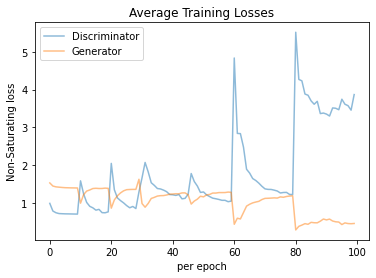

In [ ]:
t=Trainer()
t.training_loop()